In [1]:
from RNN_QSR import *

cuda:0 _CudaDeviceProperties(name='NVIDIA GeForce RTX 3080 Ti', major=8, minor=6, total_memory=12287MB, multi_processor_count=80)


In [2]:
class FastMaskedTransformerEncoder(nn.Module):#(torch.jit.ScriptModule):
    """
    Base class for a fast, masked transformer
    
    """
    def __init__(self,Nh=128,dropout=0.0,num_layers=2,nhead=8,device=device):
        super(FastMaskedTransformerEncoder, self).__init__()
        #print(nhead)
        #Encoder only transformer
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=Nh, nhead=nhead, dropout=dropout)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.device=device
    def set_mask(self, L):
        # type: (int)
        """
        Set the transformer mask for a sequence of length L
        Inputs: 
            L (int) - the desired sequence length
        """
        # take the log of a lower triangular matrix
        self.mask = torch.log(torch.tril(torch.ones([L,L],device=self.device)))        
        
    def forward(self, input):
        # type: (Tensor)->Tensor
        """Run the transformer on a sequence of length L
            Inputs:
                input -  Tensor of shape [L,B,Nh]
            Outputs:    
                Tensor of shape [L,B,Nh]
        """
        return self.transformer(input,self.mask)
    
    def next_with_cache(self,tgt,cache=None,idx=-1):
        # type: (Tensor,Optional[Tensor],int) -> Tuple[Tensor,Tensor]
        """Efficiently calculates the next output of a transformer given the input sequence and 
        cached intermediate layer encodings of the input sequence
        
        Inputs:
            tgt - Tensor of shape [L,B,Nh]
            cache - Tensor of shape ?
            idx - index from which to start
            
        Outputs:
            output - Tensor of shape [?,B,Nh]
            new_cache - Tensor of shape ?
        """
        #HMMM
        output = tgt
        new_token_cache = []
        #go through each layer and apply self attention only to the last input
        for i,layer in enumerate(self.transformer.layers):
            
            tgt=output
            #have to merge the functions into one
            src = tgt[idx:, :, :]
            mask = None if idx==-1 else self.mask[idx:]

            # self attention part
            src2 = layer.self_attn(
                src,#only do attention with the last elem of the sequence
                tgt,
                tgt,
                attn_mask=mask,  
                key_padding_mask=None,
            )[0]
            #straight from torch transformer encoder code
            src = src + layer.dropout1(src2)
            src = layer.norm1(src)
            src2 = layer.linear2(layer.dropout(layer.activation(layer.linear1(src))))
            src = src + layer.dropout2(src2)
            src = layer.norm2(src)
            #return src
            
            output = src#self.next_attn(output,layer,idx)
            new_token_cache.append(output)
            if cache is not None:
                #layers after layer 1 need to use a cache of the previous layer's output on each input
                output = torch.cat([cache[i], output], dim=0)

        #update cache with new output
        if cache is not None:
            new_cache = torch.cat([cache, torch.stack(new_token_cache, dim=0)], dim=1)
        else:
            new_cache = torch.stack(new_token_cache, dim=0)

        return output, new_cache
    
    def make_cache(self,tgt):
        # type: (Tensor) -> Tuple[Tensor,Tensor]
        """
        Equivalent to forward, but the intermediate outputs are also returned
        Inputs:
            tgt - Tensor of shape [L,B,Nh]
        Outputs:
            output - Tensor of shape [L,B,Nh]
            new_cache - Tensor of shape [?,L,B,Nh]
        """
        output = tgt
        new_token_cache = []
        #go through each layer and apply self attention only to the last input
        for i, layer in enumerate(self.transformer.layers):
            output = layer(output,src_mask=self.mask)#self.next_attn(output,layer,0)
            new_token_cache.append(output)
        #create cache with tensor
        new_cache = torch.stack(new_token_cache, dim=0)
        return output, new_cache

In [3]:
class PE2D(nn.Module):
    """Sequence-First 2D Positional Encoder"""
    #TODO: Positional encoding is wrong because the spins are at index i+1 when we sample and get probabilities
    def __init__(self, d_model, Lx,Ly,device,n_encode=None):
        
        super().__init__()
        assert (d_model%4==0)
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(Lx*Ly, d_model)
        
        if type(n_encode)==type(None):
            n_encode=3*d_model//4
        for pos in range(Lx*Ly):
            x=pos//Ly
            y=pos%Ly
            # Only going to fill 3/4 of the matrix so the
            # occupation values are preserved
            for i in range(0, n_encode, 4):
                
                #x direction encoding
                pe[pos, i] =                 math.sin(x / (10000 ** ((2 * i)/n_encode)))
                pe[pos, i + 1] =                 math.cos(x / (10000 ** ((2 * (i + 1))/n_encode)))
                #y direction encoding
                pe[pos, i+2] =                 math.sin(y / (10000 ** ((2 * i)/n_encode)))
                pe[pos, i + 3] =                 math.cos(y / (10000 ** ((2 * (i + 1))/n_encode)))
                
        self.pe = pe.unsqueeze(1).to(device)
        self.L=Lx*Ly
    
    def forward(self, x):
        """
        Adds a 2D positional encoding of size d_model to x
        Inputs:
            Tensor of shape [L,B,?]
        Outputs:
            Tensor of shape [L,B,d_model]
        """
        if self.d_model%x.shape[-1]!=0:
            return x.repeat(1,1,self.d_model//x.shape[-1]+1)[:,:,:self.d_model] + self.pe[:x.shape[0]]
        return x.repeat(1,1,self.d_model//x.shape[-1]) + self.pe[:x.shape[0]]
    
class PE1D(nn.Module):
    """Sequence-First 1D Positional Encoder"""
    def __init__(self, d_model, L,device,n_encode=None):
        super().__init__()
        assert (d_model%4==0)
        self.d_model = d_model
        # create constant 'pe' matrix with values dependent on 
        # pos and i
        pe = torch.zeros(L, d_model)
        if type(n_encode)==type(None):
            n_encode=3*d_model//4
        for pos in range(L):
            # Only going to fill 3/4 of the matrix so the
            # occupation values are preserved
            for i in range(0, n_encode, 2):
                #position encoding
                pe[pos, i] =                 math.sin(pos / (10000 ** ((2 * i)/n_encode)))
                pe[pos, i + 1] =             math.cos(pos / (10000 ** ((2 * (i + 1))/n_encode)))
        self.pe = pe.unsqueeze(1).to(device)
        self.L=L
    
    def forward(self, x):
        """
        Adds a 1D positional encoding of size d_model to x
        Inputs:
            Tensor of shape [L,B,?]
        Outputs:
            Tensor of shape [L,B,d_model]
        """
        if self.d_model%x.shape[-1]!=0:
            return x.repeat(1,1,self.d_model//x.shape[-1]+1)[:,:,:self.d_model] + self.pe[:x.shape[0]]
        return x.repeat(1,1,self.d_model//x.shape[-1]) + self.pe[:x.shape[0]]

def pe2Dtest(Lx,Ly):
    pe = torch.zeros(Lx*Ly, 2)
    for pos in range(Lx*Ly):
        x=pos//Ly
        y=pos%Ly
        # Only going to fill 3/4 of the matrix so the
        # occupation values are preserved
        #x direction encoding
        pe[pos, 0] =                 x
        #y direction encoding
        pe[pos, 1] =                 y
    return pe

In [4]:
class Patch2D(nn.Module):
    def __init__(self,n,Lx):
        super().__init__()
        self.n=n
        self.Lx=Lx
    def forward(self,x):
        # type: (Tensor) -> Tensor
        n,Lx=self.n,self.Lx
        """Unflatten a tensor back to 2D, break it into nxn chunks, then flatten the sequence and the chunks
            Input:
                Tensor of shape [B,L]
            Output:
                Tensor of shape [B,L//n^2,n^2]
        """
        #make the input 2D then break it into 2x2 chunks 
        #afterwards reshape the 2x2 chunks to vectors of size 4 and flatten the 2d bit
        return x.view([x.shape[0],Lx,Lx]).unfold(-2,n,n).unfold(-2,n,n).reshape([x.shape[0],int(Lx*Lx//n**2),int(n**2)])

    def reverse(self,x):
        # type: (Tensor) -> Tensor
        """Inverse function of forward
            Input:
                Tensor of shape [B,L//n^2,n^2]
            Output:
                Tensor of shape [B,L]
        """
        n,Lx=self.n,self.Lx
        # original sequence order can be retrieved by chunking twice more
        #in the x-direction you should have chunks of size 2, but in y it should
        #be chunks of size Ly//2
        return x.unfold(-2,Lx//n,Lx//n).unfold(-2,n,n).reshape([x.shape[0],Lx*Lx])
    
class Patch1D(nn.Module):
    def __init__(self,n,L):
        super().__init__()
        self.n=n
        self.L = L
    def forward(self,x):
        # type: (Tensor) -> Tensor
        """Break a tensor into chunks, essentially a wrapper of reshape
            Input:
                Tensor of shape [B,L]
            Output:
                Tensor of shape [B,L/n,n]
        """
        #make the input 2D then break it into 2x2 chunks 
        #afterwards reshape the 2x2 chunks to vectors of size 4 and flatten the 2d bit
        return x.reshape([x.shape[0],self.L//self.n,self.n])

    def reverse(self,x):
        # type: (Tensor) -> Tensor
        """Inverse function of forward
            Input:
                Tensor of shape [B,L/n,n]
            Output:
                Tensor of shape [B,L]
        """
        # original sequence order can be retrieved by chunking twice more
        #in the x-direction you should have chunks of size 2, but in y it should
        #be chunks of size Ly//2
        return x.reshape([x.shape[0],self.L])
    
    
@torch.jit.script
def patch2onehot(patch):
    #moving the last dimension to the front
    patch=patch.unsqueeze(0).transpose(-1,0).squeeze(-1)
    out=torch.zeros(patch.shape[1:],device=patch.device)
    for i in range(4):
        out+=patch[i]<<i
    return nn.functional.one_hot(out.to(torch.int64), num_classes=16)

In [5]:
x = torch.arange(36).unsqueeze(0)

patch2d = Patch2D(3,6)

patch1d = Patch1D(3,36)

y2 = patch2d(x)

y1 = patch1d(x)

print(x.view(6,6))

print(y2)
print(patch2d.reverse(y2).view(6,6))
print(y1)
print(patch1d.reverse(y1).view(6,6))

pe2Dtest(6,6//3)

tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])
tensor([[[ 0,  1,  2,  6,  7,  8, 12, 13, 14],
         [ 3,  4,  5,  9, 10, 11, 15, 16, 17],
         [18, 19, 20, 24, 25, 26, 30, 31, 32],
         [21, 22, 23, 27, 28, 29, 33, 34, 35]]])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29],
        [30, 31, 32, 33, 34, 35]])
tensor([[[ 0,  1,  2],
         [ 3,  4,  5],
         [ 6,  7,  8],
         [ 9, 10, 11],
         [12, 13, 14],
         [15, 16, 17],
         [18, 19, 20],
         [21, 22, 23],
         [24, 25, 26],
         [27, 28, 29],
         [30, 31, 32],
         [33, 34, 35]]])
tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11],
        [12, 13, 14, 15, 16, 17],
        [18, 19, 20,

tensor([[0., 0.],
        [0., 1.],
        [1., 0.],
        [1., 1.],
        [2., 0.],
        [2., 1.],
        [3., 0.],
        [3., 1.],
        [4., 0.],
        [4., 1.],
        [5., 0.],
        [5., 1.]])

In [6]:
class TF(Sampler):
    """Same architecture as SlowTransformer (weights can be shared) but with improvements to sampling and labelling which
    can give a 2x performance boost"""
    
    def __init__(self,Lx,Ly,device=device,Nh=128,dropout=0.0,num_layers=2,nhead=8, **kwargs):
        """
        Parameters:
            Lx,Ly (int) -- Sequence dimensions
            Nh (int) -- size of the input vector at each sequence element (same as d_model)
            decoder (bool) -- whether to use a TF decoder or encoder. Using a decoder isn't currently implemented
        """
        super(TF, self).__init__(device=device)
        
        self.pe = PE2D(Nh, Lx,Ly,device)
        
        self.transformer = FastMaskedTransformerEncoder(Nh=Nh,dropout=dropout,num_layers=num_layers,nhead=nhead)        
        
        self.lin = nn.Sequential(
                nn.Linear(Nh,Nh),
                nn.ReLU(),
                nn.Linear(Nh,1),
                nn.Sigmoid()
            )
        
        
        self.set_mask(Lx*Ly)
        self.to(device)
        
    def set_mask(self, L):
        # type: (int)
        """Initialize the self-attention mask"""
        # take the log of a lower triangular matrix
        self.L=L
        self.transformer.set_mask(L)
        self.pe.L=L

    def forward(self, input):
        
        # input is shape [B,L,1]
        # add positional encoding to get shape [B,L,Nh]
        if input.shape[1]!=self.L:
            self.set_mask(input.shape[1])
        
        input=self.pe(input.transpose(1,0))
        output = self.transformer(input)
        output = self.lin(output.transpose(1,0))
        return output
    
    
    def logprobability(self,input):
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        
        #Input should have shape [B,L,1]
        B,L,one=input.shape
        
        #first prediction is with the zero input vector
        data=torch.zeros([B,L,one],device=self.device)
        #data is the input vector shifted one to the right, with the very first entry set to zero instead of using pbc
        data[:,1:,:]=input[:,:-1,:]
        
        #real is going to be a set of actual values
        real=input
        #and pred is going to be a set of probabilities
        #if real[i]=1 than you multiply your conditional probability by pred[i]
        #if real[i]=0 than you multiply by 1-pred[i]
        pred = self.forward(data)
        ones = real*pred
        zeros=(1-real)*(1-pred)
        total = ones+zeros
        #this is the sum you see in the cell above
        #add 1e-10 to the prediction to avoid nans when total=0
        logp=torch.sum(torch.log(total+1e-10),dim=1).squeeze(1)
        return logp
    def _off_diag_labels(self,sample,B,L,grad,D=1):
        """label all of the flipped states  - set D as high as possible without it slowing down runtime
        Parameters:
            sample - [B,L,1] matrix of zeros and ones for ground/excited states
            B,L (int) - batch size and sequence length
            D (int) - Number of partitions sequence-wise. We must have L%D==0 (D divides L)
            
        Outputs:
            
            sample - same as input
            probs - [B,L] matrix of probabilities of states with the jth excitation flipped
        """
        sflip = torch.zeros([B,L,L,1],device=self.device)
        #collect all of the flipped states into one array
        for j in range(L):
            #get all of the states with one spin flipped
            sflip[:,j] = sample*1.0
            sflip[:,j,j] = 1-sflip[:,j,j]
        #compute all of their logscale probabilities
        with torch.no_grad():
            #prepare sample to be used as cache
            B,L,one=sample.shape
            dsample=torch.zeros([B,L,one],device=self.device)
            dsample[:,1:,:]=sample[:,:-1,:]

            #add positional encoding and make the cache
            out,cache=self.transformer.make_cache(self.pe(dsample.transpose(1,0)))

            probs=torch.zeros([B,L],device=self.device)
            #expand cache to group L//D flipped states
            cache=cache.unsqueeze(2)

            #this line took like 1 hour to write I'm so sad
            #the cache has to be shaped such that the batch parts line up
            cache=cache.repeat(1,1,L//D,1,1).transpose(2,3).reshape(cache.shape[0],L,B*L//D,cache.shape[-1])

            pred0 = self.lin(out.transpose(1,0))
            ones = sample*pred0
            zeros=(1-sample)*(1-pred0)
            total0 = ones+zeros

            for k in range(D):

                N = k*L//D
                #next couple of steps are crucial          
                #get the samples from N to N+L//D
                #Note: samples are the same as the original up to the Nth spin
                real = sflip[:,N:(k+1)*L//D]
                #flatten it out 
                tmp = real.reshape([B*L//D,L,1])
                #set up next state predction
                fsample=torch.zeros(tmp.shape,device=self.device)
                fsample[:,1:,:]=tmp[:,:-1,:]
                # put sequence before batch so you can use it with your transformer
                tgt=self.pe(fsample.transpose(1,0))
                #grab your transformer output
                out,_=self.transformer.next_with_cache(tgt,cache[:,:N],N)

                # self.lin actually does some repeated work but it's probably
                # negligable compared to the time attention takes
                output = self.lin(out[N:].transpose(1,0))
                # reshape output separating batch from spin flip grouping
                pred = output.view([B,L//D,L-N,1])
                real=real[:,:,N:]
                ones = real*pred
                zeros=(1-real)*(1-pred)
                total = ones+zeros
                #sum across the sequence for probabilities
                logp=torch.sum(torch.log(total+1e-10),dim=2).squeeze(2)
                logp+=torch.sum(torch.log(total0[:,:N]+1e-10),dim=1)
                probs[:,N:(k+1)*L//D]=logp
                
        return sample,probs
        
    def sample(self,B,L):
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        #return (torch.rand([B,L,1],device=device)<0.5).to(torch.float32)
        #Sample set will have shape [B,L,1]
        #need one extra zero batch at the start for first pred hence input is [L+1,B,1] 
        #transformers don't do batch first so to save a bunch of transpose calls 
        input = torch.zeros([L+1,B,1],device=self.device)
        #self.set_mask(L)
        
        cache=None
        with torch.no_grad():
          for idx in range(1,L+1):
            #run the rnn on shape [B,1,1]   
            #encode the input to the proper shape
            encoded_input = self.pe(input[:idx,:,:])
                        
            #Get transformer output
            output,cache = self.transformer.next_with_cache(encoded_input,cache)
            #if probs[i]=1 then there should be a 100% chance that sample[i]=1
            #if probs[i]=0 then there should be a 0% chance that sample[i]=1
            #stands that we generate a random uniform u and take int(u<probs) as our sample
            probs=self.lin(output[-1,:,:])
            sample = (torch.rand([B,1],device=device)<probs).to(torch.float32)
            input[idx,:,:]=sample
        #input's first entry is zero to get a predction for the first atom
        #print(".",end="")
        return input.transpose(1,0)[:,1:,:]

In [7]:
class PTFBase(Sampler):#(torch.jit.ScriptModule):
    """
    Base class for the two patch transformer architectures 
    
    Architexture wise this is how a patched transformer works:
    
    You give it a (2D) state and it patches it into groups of 4 (think of a 2x2 cnn filter with stride 2). It then tells you
    the probability of each patch given it and all previous patches in your sequence using masked attention.
    
    Outputs should either be size 1 (the probability of the current patch which is input) or size 16 (for 2x2 patches where 
    the probability represented is of each potential patch)
    
    """
    def __init__(self,Lx,_2D=False,device=device,Nh=128,dropout=0.0,num_layers=2,nhead=8,outsize=1, **kwargs):
        super(PTFBase, self).__init__()
        #print(nhead)
        if _2D:
            self.pe = PE2D(Nh, Lx//2,Lx//2,device)
            self.patch=Patch2D(2,Lx)
        else:
            self.pe = PE1D(Nh,Lx//4,device)
            self.patch=Patch1D(4,Lx)
        self.device=device
        #Encoder only transformer
        #misinterperetation on encoder made it so this code does not work
        self.transformer = FastMaskedTransformerEncoder(Nh=Nh,dropout=dropout,num_layers=num_layers,nhead=nhead)       
        
        self.lin = nn.Sequential(
                nn.Linear(Nh,Nh),
                nn.ReLU(),
                nn.Linear(Nh,outsize),
                nn.Sigmoid() if outsize==1 else nn.Softmax(dim=-1)
            )
        
        self.Lx=Lx
        if _2D:
            self.set_mask(Lx**2//4)
        else:
            self.set_mask(Lx//4)
        
        self.options=torch.zeros([16,4],device=self.device)
        tmp=torch.arange(16,device=self.device)
        for i in range(4):
            self.options[:,i]=(tmp>>i)%2
        
        
        self.to(device)
        
    def set_mask(self, L):
        # type: (int)
        """Initialize the self-attention mask"""
        # take the log of a lower triangular matrix
        self.L=L
        self.transformer.set_mask(L)
        self.pe.L=L
        
        
    def forward(self, input):
        # input is shape [B,L,1]
        # add positional encoding to get shape [B,L,Nh]
        if input.shape[1]//4!=self.L:
            self.set_mask(input.shape[1]//4)
        #pe should be sequence first [L,B,Nh]
        input=self.pe(self.patch(input.squeeze(-1)).transpose(1,0))
        output = self.transformer(input)
        output = self.lin(output.transpose(1,0))
        return output
    
# In[7]:


class PTF(PTFBase):
    """Note: logprobability IS normalized 
    
    Architexture wise this is how it works:
    
    You give it a (2D) state and it patches it into groups of 4 (think of a 2x2 cnn filter with stride 2). It then tells you
    the probability of each potential patch given all previous patches in your sequence using masked attention.
    
    
    This model has 16 outputs, which describes the probability distrubition for the nth patch when given the first n-1 patches
    
    """
    def __init__(self,Lx,**kwargs):
        #only important bit is that outsize = 16
        super(PTF, self).__init__(Lx,outsize=16,**kwargs)
    @torch.jit.export
    def logprobability(self,input):
        # type: (Tensor) -> Tensor
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
        
        if input.shape[1]//4!=self.L:
            self.set_mask(input.shape[1]//4)
        #pe should be sequence first [L,B,Nh]
        
        #shape is modified to [L//4,B,4]
        input = self.patch(input.squeeze(-1)).transpose(1,0)
        
        data=torch.zeros(input.shape,device=self.device)
        data[1:]=input[:-1]
        
        #[L//4,B,4] -> [L//4,B,Nh]
        encoded=self.pe(data)
        #shape is preserved
        output = self.transformer(encoded)
        # [L//4,B,Nh] -> [L//4,B,16]
        output = self.lin(output)
        
        #real is going to be a onehot with the index of the appropriate patch set to 1
        #shape will be [L//4,B,16]
        real=patch2onehot(input)
        
        #[L//4,B,16] -> [L//4,B]
        total = torch.sum(real*output,dim=-1)
        #[L//4,B] -> [B]
        logp=torch.sum(torch.log(total+1e-10),dim=0)
        return logp   
    
    @torch.jit.export
    def sample(self,B,L,cache=None):
        # type: (int,int,Optional[Tensor]) -> Tensor
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        #length is divided by four due to patching
        L=L//4
        
        #return (torch.rand([B,L,1],device=device)<0.5).to(torch.float32)
        #Sample set will have shape [B,L,1]
        #need one extra zero batch at the start for first pred hence input is [L+1,B,1] 
        input = torch.zeros([L+1,B,4],device=self.device)
         
        with torch.no_grad():
          for idx in range(1,L+1):
            
            #pe should be sequence first [L,B,Nh]
            encoded_input = self.pe(input[:idx,:,:])
                        
            #Get transformer output
            output,cache = self.transformer.next_with_cache(encoded_input,cache)
            #check out the probability of all 16 vectors
            probs=self.lin(output[-1,:,:]).view([B,16])

            #sample from the probability distribution
            indices = torch.multinomial(probs,1,False).squeeze(1)
            #extract samples
            sample = self.options[indices]
            
            #set input to the sample that was actually chosen
            input[idx] = sample
            
        #remove the leading zero in the input    
        input=input[1:]
        #sample is repeated 16 times at 3rd index so we just take the first one
        return self.patch.reverse(input.transpose(1,0)).unsqueeze(-1)
    
    
    @torch.jit.export
    def _off_diag_labels(self,sample,B,L,grad,D=1):
        # type: (Tensor,int,int,bool,int) -> Tuple[Tensor, Tensor]
        """label all of the flipped states  - set D as high as possible without it slowing down runtime
        Parameters:
            sample - [B,L,1] matrix of zeros and ones for ground/excited states
            B,L (int) - batch size and sequence length
            D (int) - Number of partitions sequence-wise. We must have L%D==0 (D divides L)
            
        Outputs:
            
            sample - same as input
            probs - [B,L] matrix of probabilities of states with the jth excitation flipped
        """
        
        
        
        sample0=sample
        #sample is batch first at the moment
        sample = self.patch(sample.squeeze(-1))
        
        sflip = torch.zeros([B,L,L//4,4],device=self.device)
        #collect all of the flipped states into one array
        for j in range(L//4):
            #have to change the order of in which states are flipped for the cache to be useful
            for j2 in range(4):
                sflip[:,j*4+j2] = sample*1.0
                sflip[:,j*4+j2,j,j2] = 1-sflip[:,j*4+j2,j,j2]
            
        #switch sample into sequence-first
        sample = sample.transpose(1,0)
            
        #compute all of their logscale probabilities
        with torch.no_grad():
            

            data=torch.zeros(sample.shape,device=self.device)
            data[1:]=sample[:-1]
            
            #[L//4,B,4] -> [L//4,B,Nh]
            encoded=self.pe(data)
            
            #add positional encoding and make the cache
            out,cache=self.transformer.make_cache(encoded)
            probs=torch.zeros([B,L],device=self.device)
            #expand cache to group L//D flipped states
            cache=cache.unsqueeze(2)

            #this line took like 1 hour to write I'm so sad
            #the cache has to be shaped such that the batch parts line up
                        
            cache=cache.repeat(1,1,L//D,1,1).transpose(2,3).reshape(cache.shape[0],L//4,B*L//D,cache.shape[-1])

            pred0 = self.lin(out)
            #shape will be [L//4,B,16]
            real=patch2onehot(sample)
            #[L//4,B,16] -> [B,L//4]
            total0 = torch.sum(real*pred0,dim=-1).transpose(1,0)

            for k in range(D):

                N = k*L//D
                #next couple of steps are crucial          
                #get the samples from N to N+L//D
                #Note: samples are the same as the original up to the Nth spin
                real = sflip[:,N:(k+1)*L//D]
                #flatten it out and set to sequence first
                tmp = real.reshape([B*L//D,L//4,4]).transpose(1,0)
                #set up next state predction
                fsample=torch.zeros(tmp.shape,device=self.device)
                fsample[1:]=tmp[:-1]
                # put sequence before batch so you can use it with your transformer
                tgt=self.pe(fsample)
                #grab your transformer output
                out,_=self.transformer.next_with_cache(tgt,cache[:,:N//4],N//4)

                # grab output for the new part
                output = self.lin(out[N//4:].transpose(1,0))
                # reshape output separating batch from spin flip grouping
                pred = output.view([B,L//D,(L-N)//4,16])
                real = patch2onehot(real[:,:,N//4:])
                total = torch.sum(real*pred,dim=-1)
                #sum across the sequence for probabilities
                
                #print(total.shape,total0.shape)
                logp=torch.sum(torch.log(total+1e-10),dim=-1)
                logp+=torch.sum(torch.log(total0[:,:N//4]+1e-10),dim=-1).unsqueeze(-1)
                probs[:,N:(k+1)*L//D]=logp
                
        return sample0,probs
    @torch.jit.export
    def sample_with_labelsALT(self,B,L,grad=False,nloops=1):
        # type: (int,int,bool,int) -> Tuple[Tensor,Tensor,Tensor]
        sample,probs = self.sample_with_labels(B,L,grad,nloops)
        logsqrtp=probs.mean(dim=1)/2
        sumsqrtp = torch.exp(probs/2-logsqrtp.unsqueeze(1)).sum(dim=1)
        return sample,sumsqrtp,logsqrtp
    @torch.jit.export
    def sample_with_labels(self,B,L,grad=False,nloops=1):
        # type: (int,int,bool,int) -> Tuple[Tensor,Tensor]
        sample=self.sample(B,L,None)
        return self._off_diag_labels(sample,B,L,grad,nloops)

In [8]:
op=Opt()
Lx=40
op.L=Lx
op.Nh=128
op.lr=5e-4
op.Q=1
op.K=1024
op.USEQUEUE=0
#op.apply(sys.argv[1:])
op.B=op.K*op.Q
op.hamiltonian="TFIM"
#op.steps=4000
op.dir="PTF"
op.steps=12000
op.NLOOPS=10

op.h=-1.0
op.J=1.0
print(op)

L                             			40
Q                             			1
K                             			1024
B                             			1024
TOL                           			0.15
M                             			0.96875
USEQUEUE                      			0
NLOOPS                        			10
hamiltonian                   			TFIM
steps                         			12000
dir                           			PTF
Nh                            			128
lr                            			0.0005
kl                            			0.0
ffq                           			False
h                             			-1.0
J                             			1.0



In [9]:
myptf=PTF(Lx,Nh=op.Nh,num_layers=2,_2D=False)

trainsformer = torch.jit.script(myptf)
#trainsformer = torch.jit.script(PatchedRNN(Lx,Nh=op.Nh))
#trainsformer = RNN(Nh=op.Nh)
#sampleformer= PatchedRNN(Lx,Nh=op.Nh)

beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
trainsformer.parameters(), 
lr=op.lr, 
betas=(beta1,beta2)
)

C:\Users\sprag\anaconda3\envs\pytorch\lib\site-packages\torch\jit\_recursive.py:229: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))


In [10]:
if op.USEQUEUE:
    queue_train(op,(trainsformer,sampleformer,optimizer))
else:
    print("Training. . .")
    reg_train(op,(trainsformer,optimizer))

Training. . .
Output folder path established
-1.2642 40
0,-0.998|
52,-1.264|102,-1.264|151,-1.264|200,-1.264|250,-1.264|299,-1.264|348,-1.264|397,-1.264|
447,-1.264|496,-1.264|545,-1.264|595,-1.264|644,-1.264|693,-1.264|743,-1.264|792,-1.264|
841,-1.264|891,-1.264|940,-1.264|989,-1.264|1039,-1.264|1088,-1.264|1137,-1.264|1186.8282067775726 12000


In [8]:
op=Opt()
Lx=500
op.L=Lx
op.Nh=128
op.lr=5e-4
op.Q=1
op.K=512
op.USEQUEUE=0
#op.apply(sys.argv[1:])
op.B=op.K*op.Q
op.hamiltonian="TFIM"
#op.steps=4000
op.dir="PTF"
op.steps=12000
op.NLOOPS=125

op.h=-1.0
op.J=1.0
print(op)

L                             			500
Q                             			1
K                             			512
B                             			512
TOL                           			0.15
M                             			0.96875
USEQUEUE                      			0
NLOOPS                        			125
hamiltonian                   			TFIM
steps                         			12000
dir                           			PTF
Nh                            			128
lr                            			0.0005
kl                            			0.0
ffq                           			False
h                             			-1.0
J                             			1.0



In [9]:
myptf=PTF(Lx,Nh=op.Nh,num_layers=2,_2D=False)

trainsformer = torch.jit.script(myptf)
#trainsformer = torch.jit.script(PatchedRNN(Lx,Nh=op.Nh))
#trainsformer = RNN(Nh=op.Nh)
#sampleformer= PatchedRNN(Lx,Nh=op.Nh)

beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
trainsformer.parameters(), 
lr=op.lr, 
betas=(beta1,beta2)
)

C:\Users\sprag\anaconda3\envs\pytorch\lib\site-packages\torch\jit\_recursive.py:229: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  "Consider removing it.".format(name))


In [10]:
if op.USEQUEUE:
    queue_train(op,(trainsformer,sampleformer,optimizer))
else:
    print("Training. . .")
    reg_train(op,(trainsformer,optimizer))

Training. . .
Output folder path established
-1.2725 500
6,-0.967|


In [8]:
class testRNN(RNN):
    """Just adds some functions which make sure all probability labels are consistent"""
    def __init__(self,L,**kwargs):
        super(testRNN,self).__init__(**kwargs)
        self.L=L
        self.reset(1)
#functions below aren't really necessary anymore since there was no issue with masking (they serve to avoid using a mask)
    def reset(self,B):
        # type: (int) -> Tensor
        """Setup for an autoregressive transformer"""
        self._input = torch.zeros([B,self.L+1,1],device=self.device)
        self._i=1
        h0=torch.zeros([1,B,self.Nh],device=self.device)
        out,self._cache=self.rnn(torch.zeros([B,1,1],device=self.device),h0)
        out=out[:,0,:]
        probs=self.lin(out)
        return probs
    def forward(self,x):
        return x
    def getnext(self,vect):
        # type: (Tensor) -> Tensor
        """Get probability for the next output in an autoregressive transformer"""
        self._input[:,self._i]=vect
        self._i+=1
        out,self._cache=self.rnn(vect.unsqueeze(1),self._cache)
        out=out[:,0,:]
        probs=self.lin(out)
        return probs
    @torch.jit.export
    def testsample(self,B):
        # type: (int) -> Tuple[Tensor,Tensor]
        """Generate states with their probabilities in logscale"""
        #set up variables
        
        L=self.L
        probs=self.reset(B).squeeze(0)
        sprobs=torch.zeros([B],device=self.device)
        samples = torch.zeros([B,L,1],device=self.device)
        #with torch.no_grad():
        for idx in range(L):
            #loop through L sequence elements and generate next in sequence based off of probabilities
            sample = (torch.rand([B,1],device=self.device)<probs).to(torch.float32)
            #print(sample.shape,samples.shape)
            samples[:,idx] = sample
            
            ones = sample*probs
            zeros=(1-sample)*(1-probs)
            total = ones+zeros
            sprobs+=torch.log(total).squeeze(-1)
            if idx!=L-1: probs = self.getnext(sample)
                
        return samples,sprobs
    
    @torch.jit.export
    def testlabels(self,samples,B):
        # type: (Tensor,int) -> Tuple[Tensor,Tensor]
        """Get logscale probabilities of all states with one spin flipped at position j"""
        L=self.L
        with torch.no_grad():
            #print("|",end="")
            orig=samples
            samples=samples*1
            
            logprobs=torch.zeros([B,L],device=self.device)
            for k in range(L):
                #loop cross L flipped states (batched)
                probs=self.reset(B).squeeze(0)
                sprobs = torch.zeros([B],device=self.device)
                #loop across sequence
                for idx in range(L):
                    
                    sample = samples[:,idx] 
                    #kth state is flipped
                    if idx==k:
                        #multiply by 1 as a way to copy the tensor to new memory
                        sample=sample*1.0
                        #print(sample.shape)
                        sample[:,0] = 1-sample[:,0]
                    
                    ones = sample*probs
                    zeros=(1-sample)*(1-probs)
                    total = ones+zeros
                    sprobs+=torch.log(total).squeeze(-1)
                    if idx!=L-1: probs = self.getnext(sample)
                logprobs[:,k]=sprobs
        return orig,logprobs

In [9]:
mydir = "..\\NN-QSR\\RNN\\Rydberg\\64-NoQ-B=512-K=512-Nh=256-kl=0.00\\0"
op=Opt()
op.L=64
op.Nh=256
tst=torch.load(mydir+"/T")

tesRNN = torch.jit.script(testRNN(64,Nh=op.Nh))
momentum_update(0,tesRNN,tst)



In [10]:
op.K=512
op.Q=8
op.B=op.K*op.Q



# Hamiltonian parameters
N = op.L   # Total number of atoms
V = 7.0     # Strength of Van der Waals interaction
Omega = 1.0 # Rabi frequency
delta = 1.0 # Detuning 

if op.hamiltonian=="Rydberg":
    Lx=Ly=int(op.L**0.5)
    op.L=Lx*Ly
    h = Rydberg(Lx,Ly,V,Omega,delta)
else:
    #hope for the best here since there aren't defaults
    h = TFIM(op.L,op.h,op.J)


E_queue = torch.zeros([op.B],device=device)
def fill_queue(net):
    for i in range(op.Q):
        print("|",end="")
        if True:
            with torch.no_grad():
                sample,lp = net.testsample(op.K)
                _,probs= net.testlabels(sample,op.K)
            
                #print(sample.shape)
                E_i=h.localenergy(sample,lp,probs)
                E_queue[i*op.K:(i+1)*op.K]=E_i
        else:
            sample,sump,sqrtp = net.sample_with_labelsALT(op.K,op.L,grad=False,nloops=144)
            with torch.no_grad():
                lp=net.logprobability(sample)
                E_i=h.localenergyALT(sample,lp,sump,sqrtp)
                E_queue[i*op.K:(i+1)*op.K]=E_i
        
            
t=time.time()
fill_queue(tesRNN)
print(time.time()-t)

||||||||9.748275756835938


In [47]:
def errformat(m,s):
    exp = -int(np.floor(np.log(s)/np.log(10)))
    print( str(round(m,exp))+" +/- "+str(round(s,exp)))

var,mean = torch.var_mean(E_queue/op.L)

print(h.ground(),op.B)
stdv=((var/op.B)**0.5).item()
errformat(mean.item(),stdv)

-0.40522 4096
-0.40542 +/- 7e-05


In [16]:
sample,lp = tesRNN.testsample(op.K)

In [17]:
lp2=tesRNN.logprobability(sample)

In [18]:
diff=(lp-lp2)

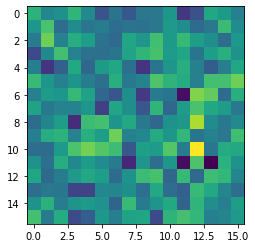

In [19]:
plt.imshow(diff.reshape(16,16).detach().cpu())

In [20]:
abs(diff).mean()

tensor(0.0005, device='cuda:0', grad_fn=<MeanBackward0>)

In [21]:
print(diff[:10])

tensor([ 6.0272e-04, -1.0681e-04,  3.0518e-05,  6.2943e-04, -8.0109e-05,
        -9.3842e-04, -4.4250e-04, -8.8882e-04, -3.8719e-04, -3.7766e-04],
       device='cuda:0', grad_fn=<SliceBackward>)


In [11]:
def reg_train2(op,to=None):
  try:

    mydir = setup_dir(op)
    
    if type(to)==type(None):
        trainrnn,optimizer=new_rnn_with_optim("GRU",op.Nh,lr=op.lr)
    else:
        trainrnn,optimizer=to
    # Hamiltonian parameters
    N = op.L   # Total number of atoms
    V = 7.0     # Strength of Van der Waals interaction
    Omega = 1.0 # Rabi frequency
    delta = 1.0 # Detuning 

    if op.hamiltonian=="Rydberg":
        Lx=Ly=int(op.L**0.5)
        op.L=Lx*Ly
        h = Rydberg(Lx,Ly,V,Omega,delta)
    else:
        #hope for the best here since there aren't defaults
        h = TFIM(op.L,op.h,op.J)
    exact_energy = h.ground()
    print(exact_energy,op.L)

    debug=[]
    losses=[]
    true_energies=[]

    # In[17]:

    i=0
    t=time.time()
    for x in range(op.steps):
        
        #gather samples
        sample,lp = trainrnn.testsample(op.K)
        
        logp=lp
        #obtain energy
        with torch.no_grad():
            _,probs= trainrnn.testlabels(sample,op.K)
            E=h.localenergy(sample,lp,probs)
            #energy mean and variance
            Ev,Eo=torch.var_mean(E)

        ERR  = Eo/(op.L)
        
        
        if op.B==1:
            loss = ((E-op.kl)*logp).mean()
        else:
            #loss = (E*logp - Eo*logp).mean()
            loss = (E*logp - (Eo+op.kl)*logp).mean()

        #Main loss curve to follow
        losses.append(ERR.cpu().item())

        #update weights
        trainrnn.zero_grad()
        loss.backward()
        optimizer.step()

        # many repeat values but it keeps the same format as no queue
        debug+=[[Ev.item()**0.5,Eo.item(),Ev.item()**0.5,Eo.item(),loss.item(),Eo.item(),0,time.time()-t]]

        if x%500==0:
            print(int(time.time()-t),end=",%.3f|"%(losses[-1]))
            if x%4000==0:print()
    print(time.time()-t,x+1)

    # In[18]:

    import os
    DEBUG = np.array(debug)
    

    if op.dir!="<NONE>":
        np.save(mydir+"/DEBUG",DEBUG)
        #print(DEBUG[-1][3]/Lx/Ly-exact_energy,DEBUG[-1][3]/Lx/Ly,DEBUG[-1][1]/Lx/Ly,exact_energy)
        trainrnn.save(mydir+"/T")
        #torch.save(samplernn,mydir+"/S")
        
  except KeyboardInterrupt:
    if op.dir!="<NONE>":
        import os
        DEBUG = np.array(debug)
        np.save(mydir+"/DEBUG",DEBUG)
        #print(DEBUG[-1][3]/Lx/Ly-exact_energy,DEBUG[-1][3]/Lx/Ly,DEBUG[-1][1]/Lx/Ly,exact_energy)
        trainrnn.save(mydir+"/T")
        #torch.save(samplernn,mydir+"/S")

In [12]:
op.hamiltonian="Rydberg"
#op.steps=4000
op.L=64
op.B=op.K=512
op.dir="TESTRNN"
op.steps=12000
op.NLOOPS=1

In [13]:
tesRNN = torch.jit.script(testRNN(64,Nh=op.Nh))

beta1=0.9;beta2=0.999
optimizer = torch.optim.Adam(
tesRNN.parameters(), 
lr=op.lr, 
betas=(beta1,beta2)
)



In [ ]:
reg_train2(op,(tesRNN,optimizer))

Output folder path established
-0.40522 64
1,2.577|
545,-0.312|1090,-0.385|1636,-0.390|2183,-0.391|2727,-0.394|3269,-0.395|3811,-0.396|4355,-0.401|
4898,-0.402|5444,-0.388|5993,-0.397|6539,-0.402|7085,-0.404|7629,-0.396|8174,-0.405|8719,-0.404|
9264,-0.405|

In [ ]:
@torch.jit.script
def genpatch2onehot(patch,p):
    # type: (Tensor,int) -> Tensor
    #moving the last dimension to the front
    patch=patch.unsqueeze(0).transpose(-1,0).squeeze(-1)
    out=torch.zeros(patch.shape[1:],device=patch.device)
    for i in range(p):
        out+=patch[i]<<i
    return nn.functional.one_hot(out.to(torch.int64), num_classes=2**p)



class PatchedRNN(Sampler):
    TYPES={"GRU":nn.GRU,"ELMAN":nn.RNN,"LSTM":nn.LSTM}
    def __init__(self,L,p,_2D=False,rnntype="GRU",Nh=128,device=device, **kwargs):
        super(PatchedRNN, self).__init__(device=device)
        
        if _2D:
            self.patch=Patch2D(p,L)
            self.L = (L**2//p**2)
            self.p=p**2
        else:
            self.patch=Patch1D(p,L)
            self.L = (L//p)
            self.p = p
        
        assert rnntype!="LSTM"
        #rnn takes input shape [B,L,1]
        self.rnn = RNN.TYPES[rnntype](input_size=self.p,hidden_size=Nh,batch_first=True)
        
        
        self.lin = nn.Sequential(
                nn.Linear(Nh,Nh),
                nn.ReLU(),
                nn.Linear(Nh,2**self.p),
                nn.Softmax(dim=-1)
            )
        self.Nh=Nh
        self.rnntype=rnntype
        
        
        self.options=torch.zeros([2**self.p,self.p],device=self.device)
        tmp=torch.arange(2**self.p,device=self.device)
        for i in range(self.p):
            self.options[:,i]=(tmp>>i)%2
            
        
        self.to(device)
    def forward(self, input):
        # h0 is shape [d*numlayers,B,H] but D=numlayers=1 so
        # h0 has shape [1,B,H]
        
        #if self.rnntype=="LSTM":
        #    h0=[torch.zeros([1,input.shape[0],self.Nh],device=self.device),
        #       torch.zeros([1,input.shape[0],self.Nh],device=self.device)]
            #h0 and c0
        #else:
        h0=torch.zeros([1,input.shape[0],self.Nh],device=self.device)
        out,h=self.rnn(input,h0)
        return self.lin(out)
    
    @torch.jit.export
    def logprobability(self,input):
        # type: (Tensor) -> Tensor
        """Compute the logscale probability of a given state
            Inputs:
                input - [B,L,1] matrix of zeros and ones for ground/excited states
            Returns:
                logp - [B] size vector of logscale probability labels
        """
                
        #shape is modified to [B,L//4,4]
        input = self.patch(input.squeeze(-1))
        data=torch.zeros(input.shape,device=self.device)
        #batch first
        data[:,1:]=input[:,:-1]
        # [B,L//4,Nh] -> [B,L//4,16]
        output = self.forward(data)
        
        #real is going to be a onehot with the index of the appropriate patch set to 1
        #shape will be [B,L//4,16]
        real=genpatch2onehot(input,self.p)
        
        #[B,L//4,16] -> [B,L//4]
        total = torch.sum(real*output,dim=-1)
        #[B,L//4] -> [B]
        logp=torch.sum(torch.log(total),dim=1)
        return logp
    @torch.jit.export
    def sample(self,B,L,cache=None):
        # type: (int,int,Optional[Tensor]) -> Tensor
        """ Generates a set states
        Inputs:
            B (int)            - The number of states to generate in parallel
            L (int)            - The length of generated vectors
        Returns:
            samples - [B,L,1] matrix of zeros and ones for ground/excited states
        """
        #length is divided by four due to patching
        L=L//self.p
        #if self.rnntype=="LSTM":
        #    h=[torch.zeros([1,B,self.Nh],device=self.device),
        #       torch.zeros([1,B,self.Nh],device=self.device)]
            #h is h0 and c0
        #else:
        h=torch.zeros([1,B,self.Nh],device=self.device)
        #Sample set will have shape [B,L,p]
        #need one extra zero batch at the start for first pred hence input is [L+1,B,1] 
        input = torch.zeros([B,L+1,self.p],device=self.device)
         
        with torch.no_grad():
          for idx in range(1,L+1):
            #out should be batch first [B,L,Nh]
            out,h=self.rnn(input[:,idx-1:idx,:],h)
            #check out the probability of all 2**p vectors
            probs=self.lin(out[:,0,:]).view([B,2**self.p])
            #sample from the probability distribution
            indices = torch.multinomial(probs,1,False).squeeze(1)
            #extract samples
            sample = self.options[indices]
            #set input to the sample that was actually chosen
            input[:,idx] = sample
        #remove the leading zero in the input    
        #sample is repeated 16 times at 3rd index so we just take the first one
        return self.patch.reverse(input[:,1:]).unsqueeze(-1)
    
    @torch.jit.export
    def sample_with_labelsALT(self,B,L,grad=False,nloops=1):
        # type: (int,int,bool,int) -> Tuple[Tensor,Tensor,Tensor]
        sample,probs = self.sample_with_labels(B,L,grad,nloops)
        logsqrtp=probs.mean(dim=1)/2
        sumsqrtp = torch.exp(probs/2-logsqrtp.unsqueeze(1)).sum(dim=1)
        return sample,sumsqrtp,logsqrtp
    @torch.jit.export
    def sample_with_labels(self,B,L,grad=False,nloops=1):
        # type: (int,int,bool,int) -> Tuple[Tensor,Tensor]
        sample=self.sample(B,L,None)
        return self._off_diag_labels(sample,B,L,grad,nloops)
    
    
    @torch.jit.export
    def _off_diag_labels(self,sample,B,L,grad,D=1):
        # type: (Tensor,int,int,bool,int) -> Tuple[Tensor, Tensor]
        """label all of the flipped states  - set D as high as possible without it slowing down runtime
        Parameters:
            sample - [B,L,1] matrix of zeros and ones for ground/excited states
            B,L (int) - batch size and sequence length
            D (int) - Number of partitions sequence-wise. We must have L%D==0 (D divides L)
            
        Outputs:
            
            sample - same as input
            probs - [B,L] matrix of probabilities of states with the jth excitation flipped
        """
        sample0=sample
        #sample is batch first at the moment
        sample = self.patch(sample.squeeze(-1))
        
        sflip = torch.zeros([B,L,L//self.p,self.p],device=self.device)
        #collect all of the flipped states into one array
        for j in range(L//self.p):
            #have to change the order of in which states are flipped for the cache to be useful
            for j2 in range(self.p):
                sflip[:,j*self.p+j2] = sample*1.0
                sflip[:,j*self.p+j2,j,j2] = 1-sflip[:,j*self.p+j2,j,j2]
            
        #compute all of their logscale probabilities
        with torch.no_grad():
            
            data=torch.zeros(sample.shape,device=self.device)
            
            data[:,1:]=sample[:,:-1]
            
            #add positional encoding and make the cache
            
            h=torch.zeros([1,B,self.Nh],device=self.device)
            
            out,_=self.rnn(data,h)
            
            #cache for the rnn is the output in this sense
            #shape [B,L//4,Nh]
            cache=out
            probs=torch.zeros([B,L],device=self.device)
            #expand cache to group L//D flipped states
            cache=cache.unsqueeze(1)

            #this line took like 1 hour to write I'm so sad
            #the cache has to be shaped such that the batch parts line up
                        
            cache=cache.repeat(1,L//D,1,1).reshape(B*L//D,L//self.p,cache.shape[-1])
                        
            pred0 = self.lin(out)
            #shape will be [B,L//4,16]
            real=genpatch2onehot(sample,self.p)
            #[B,L//4,16] -> [B,L//4]
            total0 = torch.sum(real*pred0,dim=-1)

            for k in range(D):

                N = k*L//D
                #next couple of steps are crucial          
                #get the samples from N to N+L//D
                #Note: samples are the same as the original up to the Nth spin
                real = sflip[:,N:(k+1)*L//D]
                #flatten it out and set to sequence first
                tmp = real.reshape([B*L//D,L//self.p,self.p])
                #set up next state predction
                fsample=torch.zeros(tmp.shape,device=self.device)
                fsample[:,1:]=tmp[:,:-1]
                #grab your rnn output
                if k==0:
                    out,_=self.rnn(fsample,cache[:,0].unsqueeze(0)*0.0)
                else:
                    out,_=self.rnn(fsample[:,N//self.p:],cache[:,N//self.p-1].unsqueeze(0)*1.0)
                # grab output for the new part
                output = self.lin(out)
                # reshape output separating batch from spin flip grouping
                pred = output.view([B,L//D,(L-N)//self.p,2**self.p])
                real = genpatch2onehot(real[:,:,N//self.p:],self.p)
                total = torch.sum(real*pred,dim=-1)
                #sum across the sequence for probabilities
                #print(total.shape,total0.shape)
                logp=torch.sum(torch.log(total),dim=-1)
                logp+=torch.sum(torch.log(total0[:,:N//self.p]),dim=-1).unsqueeze(-1)
                probs[:,N:(k+1)*L//D]=logp
                
        return sample0,probs